In [1]:
from typing import *
import numpy as np

from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit
sim = AerSimulator()

from util import zero, one

# Foundations II: No Cloning

The **no cloning** theorem is a claim that you cannot duplicate an *arbitrary* quantum state. In a multi-qubit system, this in some sense means that each qubit is unique. It is an important fact of quantum computation so we'll give a proof.

References
1. [Introduction to Classical and Quantum Computing: Chapter 4.4.4](https://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e4p.pdf)
2. [Introduction to Quantum Information Science: Lecture 7 by Scott Aaronson](https://www.scottaaronson.com/qclec.pdf)

## Cloning a single-qubit? Let's try it ...

Suppose that we could construct a quantum circuit that clones a single qubit $|\psi\rangle = \alpha |0\rangle + \beta |1\rangle$. Then we can find a unitary $U$ such that

$$
U|\psi 0\rangle = |\psi \psi\rangle \,.
$$

We want to show that it's impossible to construct such a U.

### Cloning is Impossible

1. Unpack the input.

\begin{align*}
|\psi 0\rangle & = |\psi\rangle \otimes |0\rangle \\
& = (\alpha |0\rangle + \beta |1\rangle) \otimes |0\rangle \\
& = \alpha |00\rangle + \beta |10\rangle
\end{align*}

2. Unpack the output.

\begin{align*}
|\psi \psi\rangle & = |\psi\rangle \otimes |\psi\rangle \\
& = (\alpha |0\rangle + \beta |1\rangle) \otimes (\alpha |0\rangle + \beta |1\rangle) \\
& = \alpha^2 |00\rangle + \alpha\beta |01\rangle + \beta\alpha |10\rangle + \beta^2 |11\rangle
\end{align*}

3. Thus

$$
\begin{pmatrix}
\alpha^2 \\
\alpha\beta \\
\alpha\beta \\
\beta^2
\end{pmatrix} = U\begin{pmatrix}
\alpha \\
0 \\
\beta \\
0
\end{pmatrix}
$$

which is impossible since $\alpha^2$ (similarly $\alpha\beta$ and $\beta^2$) is not a linear combination of $\alpha$ and $\beta$ (when one of $\alpha, \beta \neq 0$.

In [2]:
# We can also check the unitary condition
psi = np.array([1/np.sqrt(2)+0j, 0j, 1/np.sqrt(2)+0j, 0j])
U_psi = np.array([1/np.sqrt(2)+0j, 1/2+0j, 1/2+0j, 1/np.sqrt(2)+0j])
print("Does psi have unit norm:", np.allclose(1, np.linalg.norm(psi)))
print("Does U(psi) have unit norm:", np.allclose(1, np.linalg.norm(U_psi)))

Does psi have unit norm: True
Does U(psi) have unit norm: False


## Doesn't the CNOT gate copy?

Recall that the CNOT gate acts as

\begin{align*}
|ct\rangle & \phantom{\mapsto} CNOT |ct\rangle \\\hline
|00\rangle & \mapsto |00\rangle \\
|01\rangle & \mapsto |01\rangle \\
|10\rangle & \mapsto |11\rangle \\
|11\rangle & \mapsto |10\rangle \\
\end{align*}

1. Notably $|00\rangle \mapsto |00\rangle$ and $|10\rangle \mapsto |11\rangle$.
2. Why doesn't this violate the no cloning theorem?

Indeed, the circuit below seems to succeed in copying $1$ from $|q_0\rangle$ to $|q_1\rangle$.

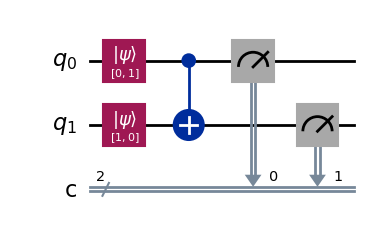

In [3]:
qc_cnot = QuantumCircuit(2, 2)
qc_cnot.initialize(one, 0); qc_cnot.initialize(zero, 1)
qc_cnot.cx(0, 1)  # 0 is control, 1 is target
qc_cnot.measure(0, 0)
qc_cnot.measure(1, 1)
qc_cnot.draw(output="mpl", style="iqp")

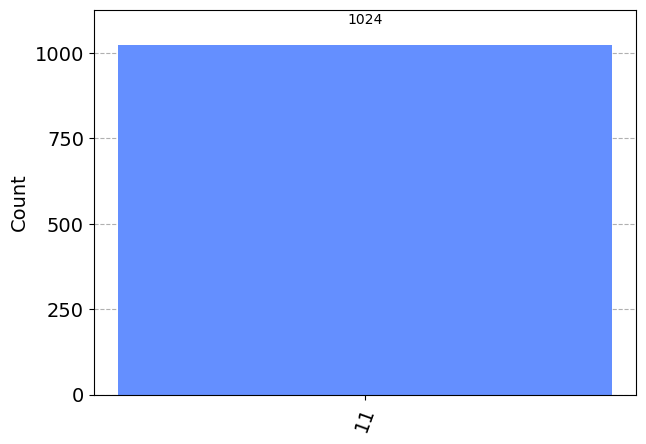

In [4]:
results = sim.run(qc_cnot, shots=1024).result()
plot_histogram(results.get_counts())

### Answer

The answer is that only **classical information** can be copied.
In other words, We need to have a degenerate case where either $\alpha=0$ or $\beta=0$.
Here's an example where we cannot copy information.

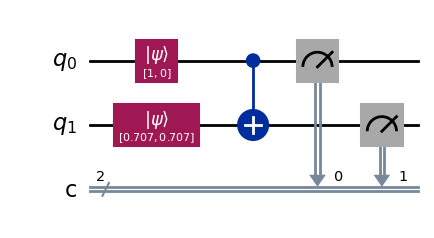

In [5]:
qc_cnot = QuantumCircuit(2, 2)
qc_cnot.initialize(zero, 0)
# Trying to copy equal superposition
qc_cnot.initialize(1/np.sqrt(2)*(zero + one), 1)
qc_cnot.cx(0, 1)  # 0 is control, 1 is target
qc_cnot.measure(0, 0)
qc_cnot.measure(1, 1)
qc_cnot.draw(output="mpl", style="iqp")

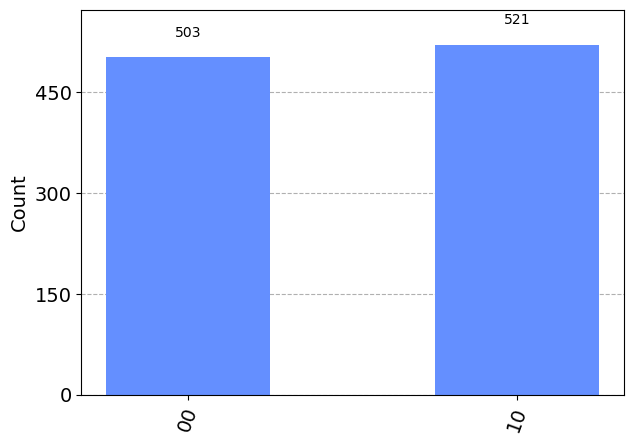

In [6]:
results = sim.run(qc_cnot, shots=1024).result()
answer = results.get_counts()
# Should expect 50% 00 and 50% 11 if we were able to copy successfully
plot_histogram(answer)

## Optional: Another proof that cloning isn't possible

1. Recall that a unitary matrix $U$ is one where

$$
\lVert U v \rVert = \lVert v \rVert \,.
$$

2. An equivalent characterization of a unitary matrix $U$ is that it also preserves inner products, i.e.,

\begin{align*}
\langle Uv, Uw \rangle & = \langle Uv| |Uw \rangle \tag{definition inner product} \\
& = \langle v| U^\dagger U |w \rangle \tag{definition bra/ket} \\
& = \langle v| |w \rangle \tag{$U^\dagger U = I$} \\
& = \langle v, w \rangle \tag{algebra} \,.
\end{align*}

### No-cloning via inner product

\begin{align*}
\langle v, w \rangle \langle 0, 0 \rangle& = \langle (v \otimes 0), (w \otimes 0) \rangle \tag{$\otimes$} \\
& = \langle U (v \otimes 0), U (w \otimes 0) \rangle \tag{$U$} \\
& = \langle v \otimes v, w  \otimes w \rangle \tag{definition cloning} \\
& = \langle v | | w\rangle \langle v | | w\rangle \tag{$\otimes$} \\
& = (\langle v, w\rangle)^2 \\
\end{align*}

This can only hold if $\langle v, w \rangle = 0$ or $\langle v, w \rangle = 1$, i.e., they are part of the same orthogonal basis.

### Probabilistic version of no cloning

The no cloning theorem is not unique to quantum computation. In particular, you also can't clone an arbitrary probabilistic state if you don't have access to the process that generated it.

## Summary

1. We stated and proved the no cloning theorem. It states that arbitrary quantum states cannot be copied.
2. Classical information can still be copied as demonstrated by the CNOT gate.